In [218]:
import pandas as pd
import numpy as np

athletes_df = pd.read_csv("athletes.csv")

athletes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11208 non-null  float64
 6   weight       10879 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


In [219]:
# заполняем пропуски и корректриуем данные
athletes_df["dob"] = pd.to_datetime(athletes_df["dob"], errors="coerce")

athletes_df["dob"] = np.where(
    athletes_df["dob"] > pd.Timestamp.today(),
    athletes_df["dob"] - pd.DateOffset(years=100),
    athletes_df["dob"],
)

athletes_df["dob"] = athletes_df["dob"].fillna(
    athletes_df.groupby(["sex", "sport"])["dob"].transform("median")
)

for i in ["height", "weight"]:
    athletes_df[i] = athletes_df[i].fillna(
        athletes_df.groupby(["sex", "sport"])[i].transform("median")
    )
    athletes_df[i] = athletes_df[i].fillna(
        athletes_df.groupby(["sex"])[i].transform("median")
    )


athletes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           11538 non-null  int64         
 1   name         11538 non-null  object        
 2   nationality  11538 non-null  object        
 3   sex          11538 non-null  object        
 4   dob          11538 non-null  datetime64[ns]
 5   height       11538 non-null  float64       
 6   weight       11538 non-null  float64       
 7   sport        11538 non-null  object        
 8   gold         11538 non-null  int64         
 9   silver       11538 non-null  int64         
 10  bronze       11538 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 991.7+ KB


/var/folders/mk/srk2d63n62qc5h8z461_xl000000gn/T/ipykernel_41047/2413949682.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  athletes_df["dob"] = pd.to_datetime(athletes_df["dob"], errors="coerce")


In [220]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

features = athletes_df[["sex", "sport", "height", "weight"]]
X = pd.get_dummies(features.drop("sex", axis=1))

le.fit(features["sex"])
y = pd.Series(data=le.transform(features["sex"]))  # 0 - female, 1 - male

# print(le.classes_)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
model = LogisticRegression(max_iter=10000, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

y_pred_proba[:5]

array([[0.02375106, 0.97624894],
       [0.56361821, 0.43638179],
       [0.10899993, 0.89100007],
       [0.03235796, 0.96764204],
       [0.54339917, 0.45660083]])

/var/folders/mk/srk2d63n62qc5h8z461_xl000000gn/T/ipykernel_41047/3003976815.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


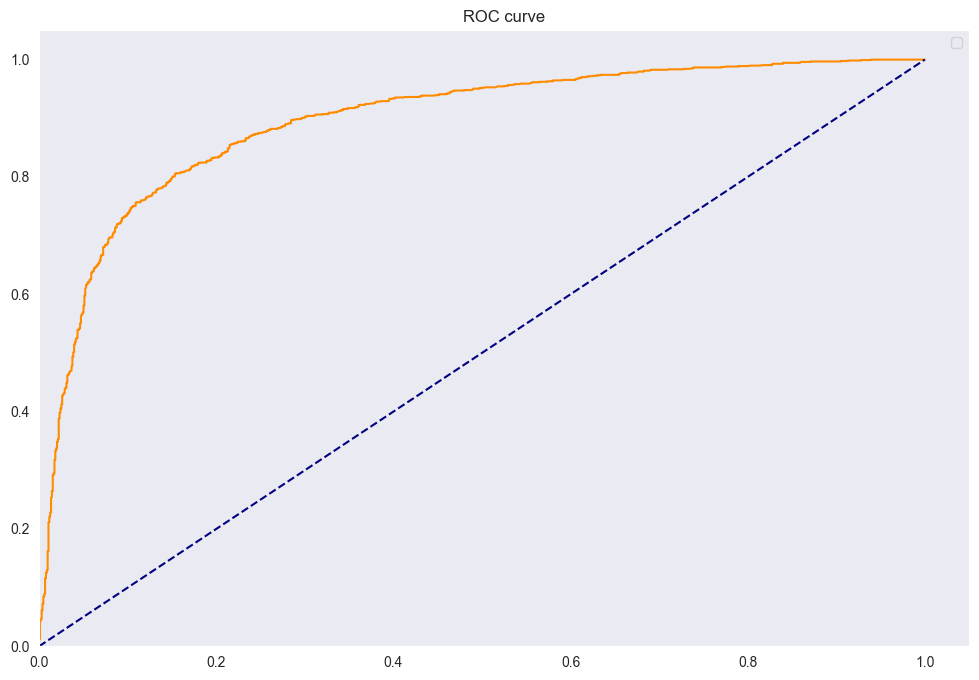

ROC-AUC score:  0.8952126929114502


In [221]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, threshold = roc_curve(y_test, y_pred_proba[:, 1])

plt.figure(figsize=(12, 8))
plt.title("ROC curve")
plt.plot(
    fpr,
    tpr,
    color="darkorange",
)
plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), color="navy", linestyle="dashed")
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.grid()
plt.legend()
plt.show()

roc_auc_scr = roc_auc_score(y_test, y_pred_proba[:, 1])
print("ROC-AUC score: ", roc_auc_scr)

In [222]:
tp, fp, fn, tn = 0, 0, 0, 0

for pred_prob, actual in zip(y_pred_proba[:, 1], y_test):
    if pred_prob >= 0.5:
        predicted = 1
    else:
        predicted = 0

    if predicted == 1:
        if actual == 1:
            tp += 1
        else:
            fp += 1
    else:
        if actual == 1:
            fn += 1
        else:
            tn += 1

In [223]:
tp, fp, fn, tn

(1037, 178, 234, 859)

In [224]:
# с какой вероятностью модель правильно классифицирует пол
accuracy = (tp + tn) / (tp + fp + fn + tn)
accuracy

0.8214904679376083

In [225]:
# доля мужчин, которые реально ими оказались
precision = tp / (tp + fp)
precision

0.8534979423868313

In [226]:
# доля правильно предсказанных мужчин в датасете
recall = tp / (tp + fn)
recall

0.8158929976396538

/var/folders/mk/srk2d63n62qc5h8z461_xl000000gn/T/ipykernel_41047/716907799.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


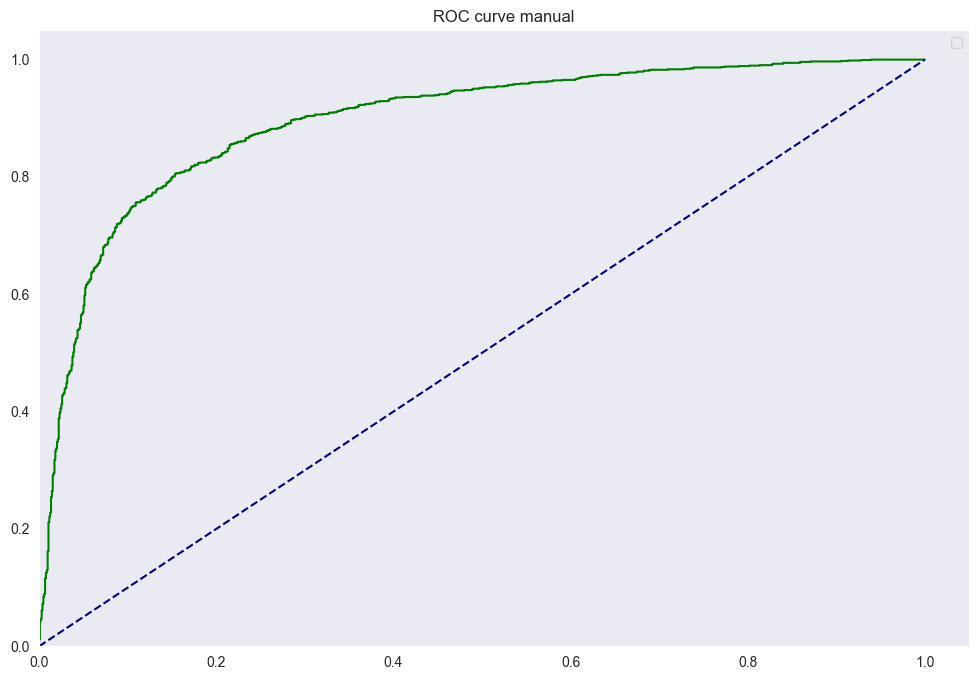

In [227]:
sort_prob = sorted(zip(y_pred_proba[:, 1], y_test), reverse=True)
sorted_probs, sorted_actual = zip(*sort_prob) if sort_prob else ([], [])

tp, fp = 0, 0
tpr_lst, fpr_lst = [0.0], [0.0]
precision_lst, recall_lst = [1.0], [0.0]

P = sum(sorted_actual)
N = len(sorted_actual) - P

for prob, actual in zip(sorted_probs, sorted_actual):
    if actual == 1:
        tp += 1
    else:
        fp += 1
    tpr = tp / P if P > 0 else 0
    fpr = fp / N if N > 0 else 0
    tpr_lst.append(tpr)
    fpr_lst.append(fpr)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 1.0
    recall = tp / P
    precision_lst.append(precision)
    recall_lst.append(recall)

if P > 0 and N > 0 and (tpr_lst[-1] < 1.0 or fpr_lst[-1] < 1.0):
    tpr_lst.append(1.0)
    fpr_lst.append(1.0)

# ручной ROC
plt.figure(figsize=(12, 8))
plt.title("ROC curve manual")
plt.plot(
    fpr_lst,
    tpr_lst,
    color="green",
)
plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), color="navy", linestyle="dashed")
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.grid()
plt.legend()
plt.show()

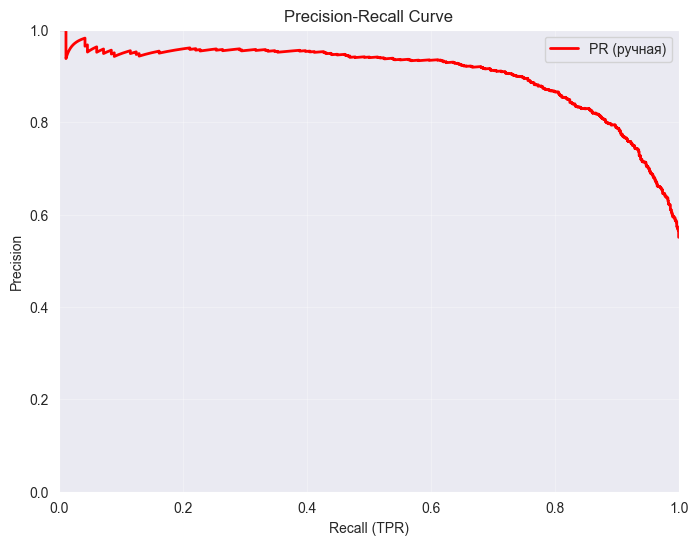

In [228]:
# ручной PR
plt.figure(figsize=(8, 6))
plt.plot(recall_lst, precision_lst, color="red", linewidth=2, label="PR (ручная)")
plt.xlabel("Recall (TPR)")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

Судя по ROC-AUC score - 0.895 - это значит, что из случайно выбранных мужчиной и женщиной модель с вероятностью 89% правильно классифицирует мужчину мужчиной.
Кривая ROC имеет большую площадь под диагональной линией и резко поднимается наверх, значит из двух классов модель находит много мужчин (выбранный позитивный класс - 1)
Кривая PR не падает примерно до порога 80%, значит мы находим много представителей целевого класса (мужчины), затем после этого порога кривая падает и модель нчинает ошибаться.

Если кривая ROC проходит ниже диагонали - это значит, что модель предсказывает хуже случайной или просто в построение кривой ROC передана метка нецелевого класса - roc_auc_score(y_test, y_pred_proba[:, 0])